In [16]:
# read data from google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# install segmentation models package
!pip install -U segmentation-models
!pip install vidstab
!pip install moviepy

In [18]:
import os
import tensorflow as tf
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import glob
import cv2
import numpy as np
from keras.utils import normalize
from keras.metrics import MeanIoU
from natsort import natsorted
import tqdm
import math
from keras.models import load_model
from moviepy.editor import *
from natsort import natsorted
import matplotlib.pyplot as plt
from datetime import datetime
from vidstab import VidStab
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

In [19]:
print(tf.config.list_physical_devices('GPU'))
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

[]


In [20]:
directory = "/content/drive/MyDrive"

In [21]:
# resize images
size_x = 384
size_y = 384

In [22]:
def stabilize_video(input_path, output_path):
    print("stabilizing video from ", input_path)

    stabilizer = VidStab()
    # stabilize video
    stabilizer.stabilize(input_path=input_path, output_path=output_path)

    stabilizer.plot_trajectory()
    plt.show()

    stabilizer.plot_transforms()
    plt.show()


def convert_video_to_frames(video_path, output_path):
    print("converting video from ", video_path)

    # read video
    vidcap = cv2.VideoCapture(video_path)
    ret,image = vidcap.read()
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    count = 0
    while ret:
        cv2.imwrite(f"{output_path}/frame%d.png" % count, image) # save frame as png file
        ret,image = vidcap.read()
        count += 1

    print(f"video converted to {count} frames")


def convert_timestamp_to_frame(video_path, timestamp):
    base_dir = os.path.realpath(video_path)

    vidcap = cv2.VideoCapture(base_dir)
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    dt_obj = datetime.strptime(timestamp,"%H:%M:%S.%f")
    time = dt_obj.time()

    # convert timestamp to seconds
    min = time.minute
    sec = time.second
    msec = time.microsecond

    milisec = min * 60 + sec + msec / 1000000
    frame_number = round(milisec * fps + 1)

    return frame_number


def convert_frames_to_video(frames_path, video_name, fps):
    print("converting frames from ", frames_path)

    file_list = glob.glob(f'{frames_path}/*.png')  # get all the pngs in the current directory
    file_list_sorted = natsorted(file_list,reverse=False)

    clips = [ImageClip(m).set_duration(0.03)
            for m in file_list_sorted]

    concat_clip = concatenate_videoclips(clips, method="compose")
    concat_clip.write_videofile(video_name, fps=fps)


def read_files(path):
    files = []

    file_list = glob.glob(f"{path}/*.*")  # get all the filesin the current directory
    file_list_sorted = natsorted(file_list,reverse=False)

    for file in file_list_sorted:
        files.append(file)

    files = np.array(files)
    len(f"read {len(files)} files")

    return files


def read_image_files(path, H, W, interpolation=False):
    files = []

    file_list = glob.glob(f"{path}/*.*")  # get all the pngs in the current directory
    file_list_sorted = natsorted(file_list,reverse=False)

    if interpolation == False:
        for file in file_list_sorted:
            img = cv2.imread(file, 1)
            img = cv2.resize(img, (H, W))
            files.append(img)
    else:
        for file in file_list_sorted:
            img = cv2.imread(file, 0)
            img = cv2.resize(img, (H, W), interpolation = cv2.INTER_NEAREST)  # otherwise ground truth changes
            files.append(img)

    files_arr = np.array(files)
    len(f"read {len(files)} images")

    return files_arr


def get_average_pixels(mask_list, return_weights=False):
    background = 0
    needle = 0
    oocyte = 0
    spermatozoid = 0

    for y in mask_list:
        background += y.size - np.count_nonzero(y)
        needle += np.count_nonzero(y == 1)
        oocyte += np.count_nonzero(y == 2)
        spermatozoid += np.count_nonzero(y == 3)

    # get average pixels on mask
    print("Needle: ", round(needle/len(mask_list)))
    print("Ooctye: ", round(oocyte/len(mask_list)))
    print("Spermatozoid: ", round(spermatozoid/len(mask_list)))
    print("Background: ", round(background/len(mask_list)))
    print()

    if return_weights==True:
        return get_weights(background, needle, oocyte, spermatozoid)


def get_weights(b, n, o, s):
    classes_count_mean = [0,0,0,0]

    classes_count_mean[0] = b
    classes_count_mean[1] = n
    classes_count_mean[2] = o
    classes_count_mean[3] = s

    classes_count_mean = [1/x for x in classes_count_mean]
    classess_weights = classes_count_mean / np.linalg.norm(classes_count_mean)

    return classess_weights


def augment_data(images, masks, size_x, size_y):
    augmented_images = []
    augmented_masks = []

    # iterate over list of images and masks
    for x, y in zip(images, masks):
        augmented_images.append(x)
        augmented_masks.append(y)

        aug = CenterCrop(size_x, size_y, p=1.0)
        augmented = aug(image=x, mask=y)
        x1 = augmented['image']
        y1 = augmented['mask']

        augmented_images.append(x1)
        augmented_masks.append(y1)

        aug = RandomRotate90(p=1.0)
        augmented = aug(image=x, mask=y)
        x2 = augmented['image']
        y2 = augmented['mask']

        augmented_images.append(x2)
        augmented_masks.append(y2)

        aug =GridDistortion(p=1.0)
        augmented = aug(image=x, mask=y)
        x3 = augmented['image']
        y3 = augmented['mask']

        augmented_images.append(x3)
        augmented_masks.append(y3)

        aug = HorizontalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x4 = augmented['image']
        y4 = augmented['mask']

        augmented_images.append(x4)
        augmented_masks.append(y4)

        aug = VerticalFlip(p=1.0)
        augmented = aug(image=x, mask=y)
        x5 = augmented['image']
        y5 = augmented['mask']

        augmented_images.append(x5)
        augmented_masks.append(y5)

    return augmented_images, augmented_masks

In [26]:
input_path = f"{directory}/frames_to_test_segmentation"
output_path = f"/content/segmentation_psp_test"

model = f"{directory}/segmentation_models/psp_softmax_1500_resnet50.hdf5"

In [27]:
frames = read_image_files(input_path, 384, 384)
len(frames)

871

In [28]:
backbone = 'resnet50'

model = load_model(model, compile=False)
preprocess_input = sm.get_preprocessing(backbone)

In [29]:
results = []
f = 0

for frame in frames:
  print("Frame: ", f)
  frame_input = np.expand_dims(frame, 0)
  test_frame = preprocess_input(frame_input)
  test = model.predict(test_frame)
  test_pred = np.argmax(test, axis=3)[0,:,:]

  results.append(test_pred)

  f+=1

preds = np.array(results)

Frame:  0
1/1 [==============================] - 2s 2s/step
Frame:  1
1/1 [==============================] - 0s 404ms/step
Frame:  2
1/1 [==============================] - 0s 386ms/step
Frame:  3
1/1 [==============================] - 0s 418ms/step
Frame:  4
1/1 [==============================] - 0s 395ms/step
Frame:  5
1/1 [==============================] - 0s 394ms/step
Frame:  6
1/1 [==============================] - 0s 434ms/step
Frame:  7
1/1 [==============================] - 0s 396ms/step
Frame:  8
1/1 [==============================] - 0s 465ms/step
Frame:  9
1/1 [==============================] - 0s 403ms/step
Frame:  10
1/1 [==============================] - 0s 409ms/step
Frame:  11
1/1 [==============================] - 0s 427ms/step
Frame:  12
1/1 [==============================] - 0s 416ms/step
Frame:  13
1/1 [==============================] - 0s 415ms/step
Frame:  14
1/1 [==============================] - 0s 402ms/step
Frame:  15
1/1 [==============================] - 0s 

Needle:  2635
Ooctye:  47398
Spermatozoid:  42
Background:  97381



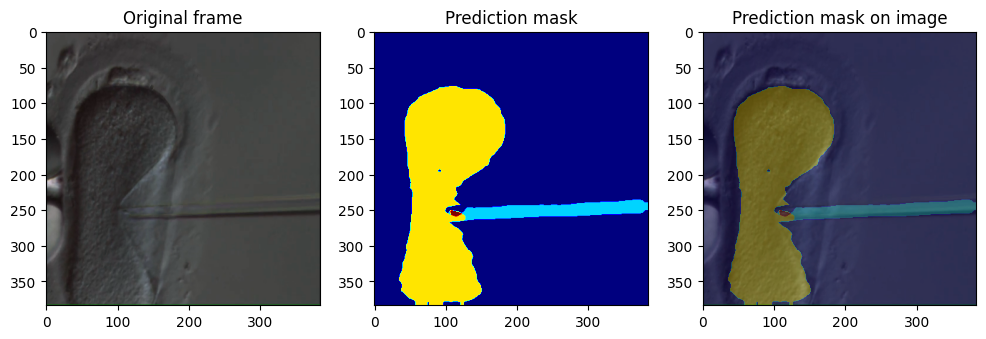

In [30]:
n = np.random.randint(len(preds)-1)
stats = get_average_pixels(preds)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Original frame')
plt.imshow(frames[n], vmin=0, vmax=3, cmap='gray')
plt.subplot(232)
plt.title('Prediction mask')
plt.imshow(preds[n], vmin=0, vmax=3, cmap='jet')
plt.subplot(233)
plt.title('Prediction mask on image')
plt.imshow(frames[n], vmin=0, vmax=3, cmap='gray')
plt.imshow(preds[n], vmin=0, vmax=3, cmap="jet", alpha=0.3)
plt.show()

In [13]:
count = 0

for i,m in zip(frames, preds):
  needle_mask = m.astype(np.uint8)
  needle_mask[needle_mask != 1] = 0
  needle_mask[needle_mask == 1] = 255
  needle_mask = np.stack((needle_mask,)*3, axis=-1)

  oocyte_mask = m.astype(np.uint8)
  oocyte_mask[oocyte_mask != 2] = 0
  oocyte_mask[oocyte_mask == 2] = 255
  oocyte_mask = np.stack((oocyte_mask,)*3, axis=-1)

  spermatozoid_mask = m.astype(np.uint8)
  spermatozoid_mask[spermatozoid_mask != 3] = 0
  spermatozoid_mask[spermatozoid_mask == 3] = 255
  spermatozoid_mask = np.stack((spermatozoid_mask,)*3, axis=-1)

  dst = cv2.addWeighted(i, 0.5, oocyte_mask, 0.5, 0)
  dst = cv2.addWeighted(dst, 0.5, needle_mask, 0.5, 0)
  dst = cv2.addWeighted(dst, 0.5, spermatozoid_mask, 0.5, 0)

  cv2.imwrite(f"{output_path}/frame_{count}.png", dst)
  count += 1

In [31]:
convert_frames_to_video(output_path, "test_psp.mp4", 20)

converting frames from  /content/segmentation_psp_test
Moviepy - Building video test_psp.mp4.
Moviepy - Writing video test_psp.mp4



Moviepy - Done !
Moviepy - video ready test_psp.mp4


In [25]:
!zip -r /content/segmentation_psp_test.zip /content/segmentation_psp_test

  adding: content/segmentation_psp_test/ (stored 0%)
  adding: content/segmentation_psp_test/frame_155.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_586.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_392.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_167.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_165.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_615.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_508.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_620.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_271.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_321.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_671.png (deflated 8%)
  adding: content/segmentation_psp_test/frame_556.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_379.png (deflated 7%)
  adding: content/segmentation_psp_test/frame_678.png (deflated